# Analysis

## Data
Struktur der Daten: Instanzname, Optimierungsstatus (Feasible oder Optimal), Fitness-Value, Lower Bound, Runtime (limitiert auf 3600 Sekunden), gefolgt von den Ergebnisvektoren, die aber für die Analyse eher zweitrangig sind

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from benchmarkrewriter.benchmark_parser import BenchmarkParser
import statistics
import seaborn as sns

In [2]:
file = 'cp_cplex_results.txt'
file_content = pd.read_csv(file, names=['name','optimation_status','fitness_value','lower_bound', 'runtime', 'result_vector1', 'result_vector2'], sep=';')
data = pd.DataFrame(file_content)

data

,name,optimation_status,fitness_value,lower_bound,runtime,result_vector1,result_vector2
0,Behnke1,Optimal,90.0,89.0,3.192,"[0, 13, 25, 36, 52, 23, 35, 47, 63, 73, 12, 26...","[2, 10, 9, 4, 16, 0, 12, 5, 12, 16, 1, 5, 15, ..."
1,Behnke10,Feasible,128.0,89.0,3600.020,"[54, 79, 90, 106, 118, 29, 56, 67, 77, 96, 11,...","[0, 4, 13, 5, 16, 1, 4, 4, 6, 16, 0, 14, 14, 6..."
2,Behnke11,Feasible,231.0,86.0,3600.040,"[147, 169, 179, 192, 207, 45, 62, 80, 100, 129...","[0, 11, 8, 12, 16, 3, 8, 15, 15, 16, 2, 4, 12,..."
3,Behnke12,Feasible,220.0,83.0,3600.050,"[155, 176, 189, 200, 210, 129, 140, 150, 174, ...","[3, 11, 8, 11, 19, 2, 9, 5, 10, 16, 1, 4, 13, ..."
4,Behnke13,Feasible,231.0,84.0,3600.040,"[122, 143, 155, 165, 182, 20, 34, 47, 59, 75, ...","[1, 15, 7, 6, 16, 0, 7, 14, 10, 18, 0, 8, 12, ..."
...,...,...,...,...,...,...,...
396,Fattahi5,Optimal,119.0,119.0,0.017,"[0, 55, 21, 55, 0, 76]","[1, 0, 0, 1, 0, 1]"
397,Fattahi6,Optimal,320.0,320.0,0.016,"[0, 47, 87, 17, 87, 237, 0, 60, 230]","[0, 0, 2, 0, 0, 2, 1, 1, 1]"
398,Fattahi7,Optimal,397.0,397.0,0.019,"[0, 117, 247, 0, 150, 205, 0, 62, 132]","[0, 1, 3, 2, 2, 2, 1, 3, 4]"
399,Fattahi8,Optimal,253.0,253.0,0.019,"[0, 25, 55, 0, 30, 85, 30, 86, 163]","[1, 1, 2, 0, 3, 3, 0, 1, 3]"


### Basic dataset characteristics

In [3]:
print(f"Dimensions of dataset: {data.shape} \n")
print(data.info())

Dimensions of dataset: (401, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               401 non-null    object 
 1   optimation_status  401 non-null    object 
 2   fitness_value      400 non-null    float64
 3   lower_bound        400 non-null    float64
 4   runtime            400 non-null    float64
 5   result_vector1     400 non-null    object 
 6   result_vector2     400 non-null    object 
dtypes: float64(3), object(4)
memory usage: 22.1+ KB
None


In [4]:
print(f"\nUnique values for 'name': {data['name'].nunique()}")
print(f"\nUnique values for 'optimation_status': {data['optimation_status'].nunique()}")


Unique values for 'name': 401

Unique values for 'optimation_status': 3


In [5]:
data.describe()

,fitness_value,lower_bound,runtime
count,400.000000,400.000000,400.000000
mean,1256.825000,1115.990000,1365.053373
std,1621.490077,1540.141256,1725.079522
min,7.000000,7.000000,0.007000
25%,501.250000,412.250000,0.499500
50%,865.500000,742.000000,8.859000
75%,1136.500000,1059.750000,3600.010000
max,8313.000000,8313.000000,3600.360000


## Report

Kennzahlen zu der jeweiligen Benchmarkinstanz (für alle Instanzen), inklusive Anzahl Maschinen, Operationen, Flexibilität und Duration Variety, und eine statistische Analyse (normalerweise eher in Form von Plots), wie zBsp:

- Laufzeit im Vergleich zu der Problemgröße (Anzahl Operationen)
- Laufzeit im Vergleich zur Flexibilität
- Laufzeit im Vergleich zur Duration Variety
- Wie viel % der Instanzen konnten tatsächlich gelöst werden ( Status = Optimal)
- Das Ganze für alle Instanzen als Gesamtübersicht und dann zum Vergleich auch noch aufgeteilt auf die einzelnen Instanzgruppen (Quellen der Benchmarkinstanzen)

Die Flexibilität ist Durchschnittliche Anzahl von verfügbaren Maschinen für jede Operation / Gesamtanzahl Maschinen im System
Die Duration Variety ist Anzahl unterschiedlicher Duration Values in der Benchmarkinstanz / Gesamtanzahl von Duration Values der Instanz

### Methods

In [6]:
# assembles the path of the FJSSPinstanes for a given name
def get_path(name: str):
    path = "../external_test_data/FJSSPinstances"

    if name.startswith("Behnke"):
        path += "/0_BehnkeGeiger/" + name 
    elif name.startswith("Brandimarte"):
        path += "/1_Brandimarte/" + name
    elif name.startswith("HurinkS"):
        path += "/2a_Hurink_sdata/" + name
    elif name.startswith("HurinkE"):
        path += "/2b_Hurink_edata/" + name 
    elif name.startswith("HurinkR"):
        path += "/2c_Hurink_rdata/" + name 
    elif name.startswith("HurinkV"):
        path += "/2d_Hurink_vdata/" + name 
    elif name.startswith("DPpaulli"):
        path += "/3_DPpaulli/" + name 
    elif name.startswith("ChambersBarnes"):
        path += "/4_ChambersBarnes/" + name
    elif name.startswith("Kacem"):
        path += "/5_Kacem/" + name
    elif name.startswith("Fattahi"):
        path += "/6_Fattahi/" + name

    return path + ".fjs"

In [7]:
#Die Flexibilität ist Durchschnittliche Anzahl von verfügbaren Maschinen für jede Operation / Gesamtanzahl Maschinen im System.
def calculate_flexibility(machines_for_all_operations, n_machines): 
    counts = []

    for m in machines_for_all_operations:
        counts.append(len(m))
    
    return statistics.mean(counts) / n_machines

#Die Duration Variety ist Anzahl unterschiedlicher Duration Values in der Benchmarkinstanz / Gesamtanzahl von Duration Values der Instanz.
def calculate_duration_variety(durations):
    counts = []

    for d in durations:
        counts.append(len(d))

    return len(set(counts)) / len(counts)

In [8]:
# prints how many instances could be solved and shows the distribution of optimation status in the provided dataset
def solved_instances(data):
    # Wie viel % der Instanzen konnten tatsächlich gelöst werden ( Status = Optimal)
    solved_instances = ([x for i, x in data.iterrows() if x["optimation_status"] == "Optimal"])
    
    print(f"{len(solved_instances) / len(data) * 100}% of all instances could be solved")
    
    fig, ax = plt.subplots(figsize=(6, 4))
    values = data["optimation_status"].value_counts()
    ax.pie(values, labels = values.index.tolist(), autopct='%1.1f%%') # donut: wedgeprops=dict(width=0.5), startangle=-40
    ax.set_title("Optimization status")
    plt.show()
    
# plots runtime vs problem size
def runtime_vs_problem_size(data): 
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(data["n_operations"], data["runtime"],  color='blue', alpha=0.5)
    ax.set_title("Runtime in comparison to problem size (number of operations)")
    ax.set_ylabel("Runtime (in seconds)")
    ax.set_xlabel("Number of operations")
    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# plots runtime vs flexibility
def runtime_vs_flexibility(data): 
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(data["flexibility"], data["runtime"], color='blue', alpha=0.5)
    ax.set_title("Runtime in comparison to flexibility")
    ax.set_ylabel("Runtime (in seconds)")
    ax.set_xlabel("Flexibility")
    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# plots runtime vs duration variety
def runtime_vs_duration_variety(data): 
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(data["duration_variety"], data["runtime"], color='blue', alpha=0.5)
    ax.set_title("Runtime in comparison to duration variety")
    ax.set_ylabel("Runtime (in seconds)")
    ax.set_xlabel("Flexibility")
    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# plots optimation status vs fitness value
def optimation_status_vs_fitness_value(data): 
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(x='optimation_status', y='fitness_value', data=data)
    #sns.violinplot(x='optimation_status', y='fitness_value', data=data)
    #ax.bar(data["optimation_status"], data["fitness_value"])
    ax.set_title("Optimation status in comparison to fitness value")
    ax.set_xlabel("Optimation status")
    ax.set_ylabel("Fitness value")
    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# plots n_jobs vs n_machines and n_machines vs n_operations
def jobs_machines_operations(data): 
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.boxplot(x='n_machines', y='n_operations', data=data)
    #ax.scatter(data["n_machines"], data["n_operations"],  color='blue', alpha=0.5)
    ax.set_title("n_machines in comparison to n_operations")
    ax.set_xlabel("Number of machines")
    ax.set_ylabel("Number of operations")

    fig2, ax2 = plt.subplots(figsize=(6, 4))
    sns.boxplot(x='n_jobs', y='n_machines', data=data)
    #ax2.scatter(data["n_jobs"], data["n_machines"],  color='blue', alpha=0.5)
    ax2.set_title("n_jobs in comparison to n_machines")
    ax2.set_xlabel("Number of jobs")
    ax2.set_ylabel("Number of machines")
    
    plt.show()

# plots n_machines vs flexibility
def n_machines_vs_flexibility(data): 
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(data["n_machines"], data["flexibility"],  color='blue', alpha=0.5)
    ax.set_title("n_machines in comparison to flexibility")
    ax.set_xlabel("Number of machines")
    ax.set_ylabel("Flexibility")
    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.show()

# prints all plots defined in the functions above
def show_all_plots(data):
    runtime_vs_problem_size(data)
    runtime_vs_flexibility(data)
    runtime_vs_duration_variety(data)
    optimation_status_vs_fitness_value(data)
    jobs_machines_operations(data)
    n_machines_vs_flexibility(data)
    solved_instances(data)

In [9]:
# reads all instances which occur in the input data and converts them into the encoding class
def get_encodings_for_group(group): 
    all_encodings = pd.DataFrame()
    
    for i, row in group.iterrows():
        read_path = get_path(row["name"])
        parser = BenchmarkParser()
        encoding = parser.parse_benchmark(read_path)
    
        extracted_data = {
            "name": [row["name"]],
            "n_jobs": [encoding.n_jobs()], 
            "n_machines": [encoding.n_machines()],
            "n_operations": [encoding.n_operations()],
            "durations": [encoding.durations()],
            "machines_for_all_operations": [encoding.get_machines_for_all_operations()]
        }
        df = pd.DataFrame(data=extracted_data)
        df.rename(index={0: i}, inplace=True)
        
        all_encodings = pd.concat([all_encodings, df])
    
    return all_encodings

# creates a dataframe with the neccessary attributes; calculates flexibility and duration variety for each encoding
def extract_data_from_encodings(encodings):
    values = pd.DataFrame()
    
    for i, b in encodings.iterrows():
        extracted_data = {
            "name": [b["name"]],
            "n_jobs": [b["n_jobs"]],
            "n_machines": [b["n_machines"]],
            "n_operations": [b["n_operations"]],  
            "flexibility": [calculate_flexibility(b["machines_for_all_operations"], b["n_machines"])],
            "duration_variety": [calculate_duration_variety(b["durations"])]
        }
    
        df = pd.DataFrame(extracted_data)
        df.rename(index={0: i}, inplace=True)
    
        values = pd.concat([values, df])
    
    return values

### Overview

#### Create encodings

In [10]:
benchmark_encodings = get_encodings_for_group(data)
benchmark_encodings

,name,n_jobs,n_machines,n_operations,durations,machines_for_all_operations
0,Behnke1,10,20,50,"[[26, 24, 13, 26, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [8, 9, 10, 11], [8, 9, 10, 11, ..."
1,Behnke10,20,20,100,"[[25, 28, 28, 30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, ..."
2,Behnke11,50,20,250,"[[22, 25, 19, 15, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, ..."
3,Behnke12,50,20,250,"[[18, 25, 27, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, ..."
4,Behnke13,50,20,250,"[[24, 21, 23, 24, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[[0, 1, 2, 3], [4, 5, 6, 7, 8, 9, 10, 11, 12, ..."
...,...,...,...,...,...,...
396,Fattahi5,3,2,6,"[[43, 36], [64, 71], [34, 53], [36, 21], [0, 0...","[[0, 1], [0, 1], [0, 1], [0, 1], [], []]"
397,Fattahi6,3,3,9,"[[17, 0, 0], [40, 130, 0], [0, 50, 60], [30, 0...","[[0], [0, 1], [1, 2], [0], [0, 1], [2], [], []..."
398,Fattahi7,3,5,9,"[[117, 125, 0, 0, 0], [0, 130, 0, 140, 0], [0,...","[[0, 1], [1, 3], [3, 4], [0, 2], [1, 2], [2, 4..."
399,Fattahi8,3,4,9,"[[17, 25, 0, 0], [0, 30, 0, 40], [0, 0, 160, 1...","[[0, 1], [1, 3], [2, 3], [0, 2], [1, 3], [2, 3..."


In [11]:
benchmark_overview = extract_data_from_encodings(benchmark_encodings)
benchmark_overview

,name,n_jobs,n_machines,n_operations,flexibility,duration_variety
0,Behnke1,10,20,50,0.272000,0.020000
1,Behnke10,20,20,100,0.290000,0.010000
2,Behnke11,50,20,250,0.314400,0.004000
3,Behnke12,50,20,250,0.322400,0.004000
4,Behnke13,50,20,250,0.316800,0.004000
...,...,...,...,...,...,...
396,Fattahi5,3,2,6,0.666667,0.166667
397,Fattahi6,3,3,9,0.333333,0.111111
398,Fattahi7,3,5,9,0.266667,0.111111
399,Fattahi8,3,4,9,0.333333,0.111111


In [12]:
benchmark_overview.describe()

,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,401.000000,401.000000,401.000000,401.000000,401.000000
mean,18.895262,13.508728,149.890274,0.254104,0.014242
std,18.355081,13.182964,111.305359,0.148739,0.025511
min,2.000000,2.000000,4.000000,0.062222,0.002000
25%,10.000000,6.000000,75.000000,0.109000,0.004444
50%,15.000000,10.000000,100.000000,0.220000,0.010000
75%,20.000000,15.000000,225.000000,0.356000,0.013333
max,100.000000,60.000000,500.000000,0.928571,0.250000


In [13]:
merged_df = pd.merge(data, benchmark_overview, on='name')

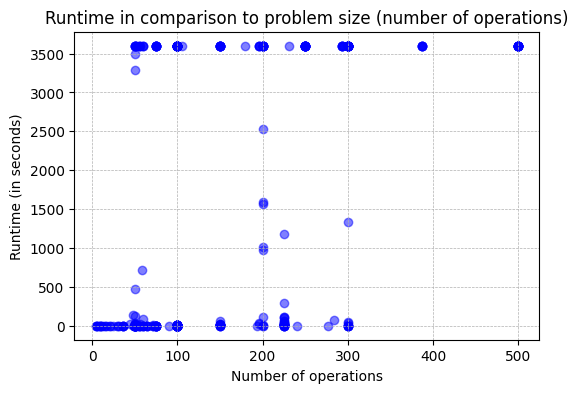

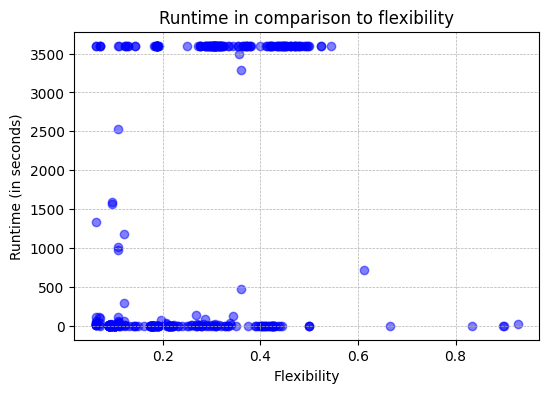

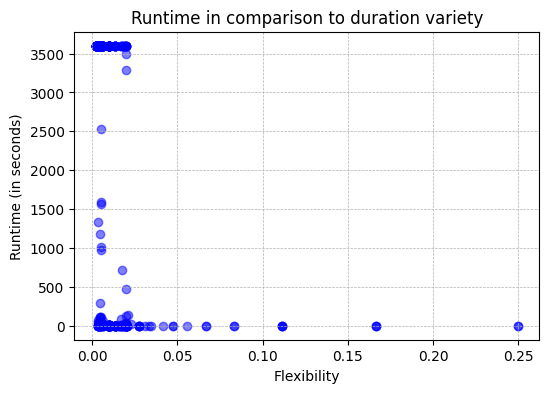

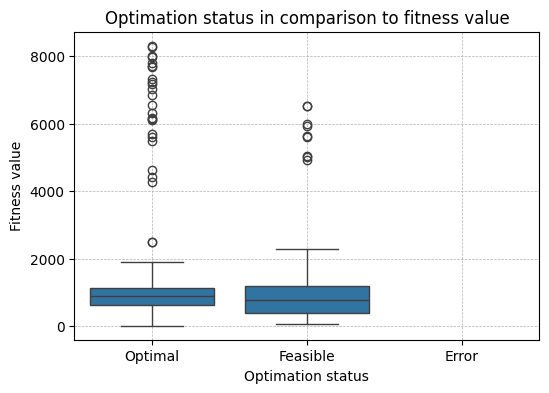

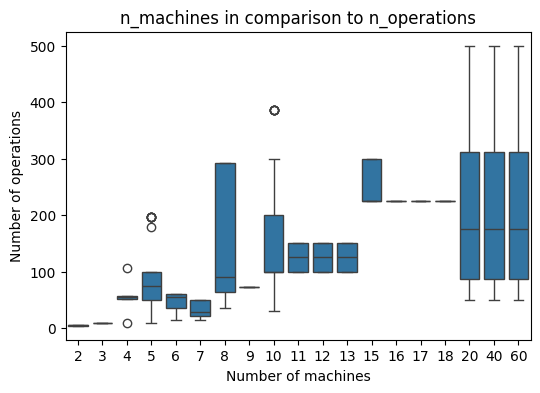

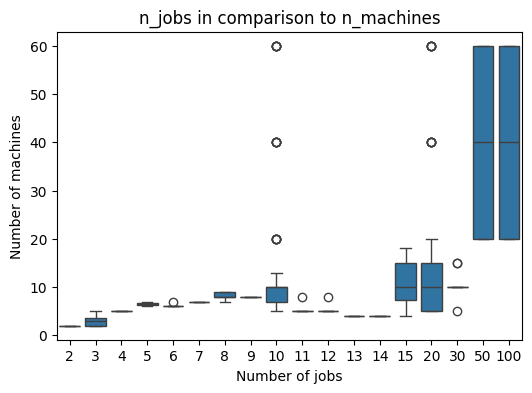

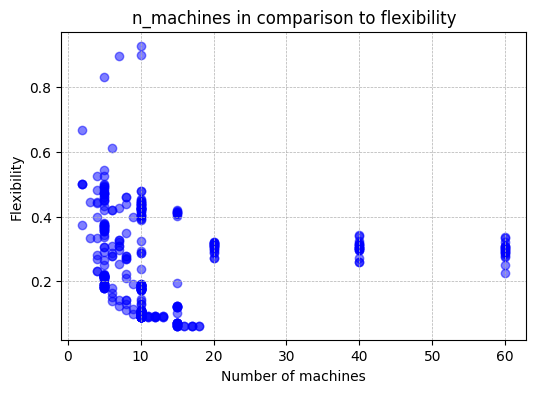

63.34164588528678% of all instances could be solved


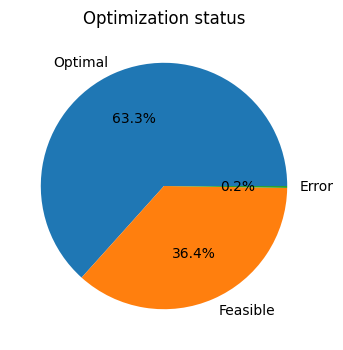

In [14]:
show_all_plots(merged_df)

### Separate instances

#### Behnke

In [15]:
behnke = pd.DataFrame([x for i, x in data.iterrows() if x["name"].startswith("Behnke")])
behnke_encodings = get_encodings_for_group(behnke)
behnke_data = extract_data_from_encodings(behnke_encodings)
behnke_merged = pd.merge(behnke, behnke_data, on='name')
behnke_merged.describe()

,fitness_value,lower_bound,runtime,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,207.866667,83.583333,2702.768650,45.000000,40.000000,225.000000,0.301283,0.009000
std,122.419737,5.090009,1567.342177,35.295364,16.467739,176.476819,0.021509,0.007059
min,84.000000,73.000000,2.628000,10.000000,20.000000,50.000000,0.224000,0.002000
25%,109.000000,80.000000,2708.051500,17.500000,20.000000,87.500000,0.291900,0.003500
50%,170.500000,84.000000,3600.040000,35.000000,40.000000,175.000000,0.304000,0.007000
75%,272.500000,87.000000,3600.102500,62.500000,60.000000,312.500000,0.314100,0.012500
max,418.000000,97.000000,3600.360000,100.000000,60.000000,500.000000,0.343000,0.020000


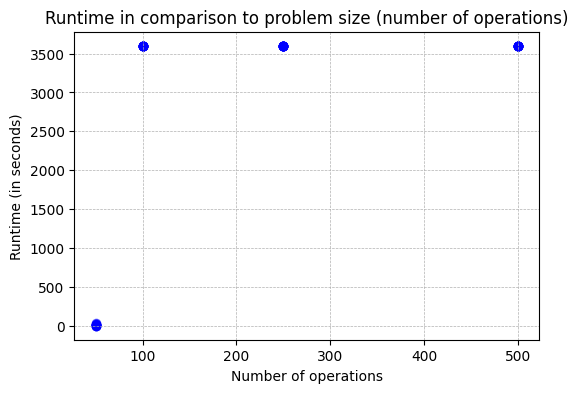

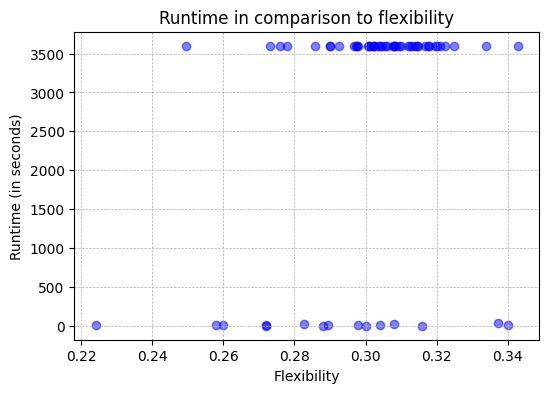

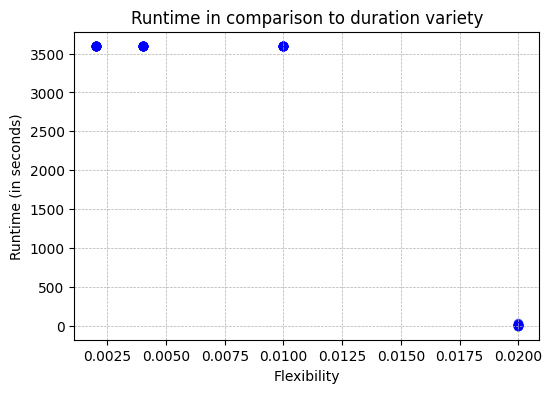

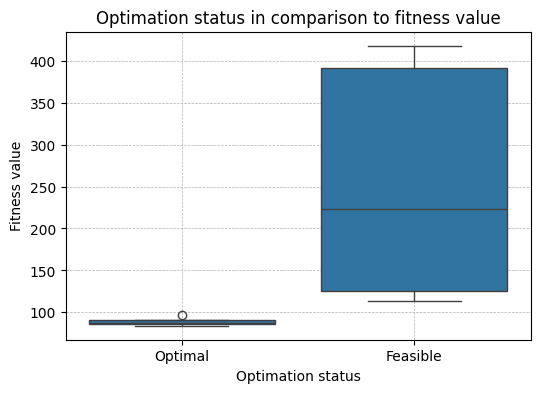

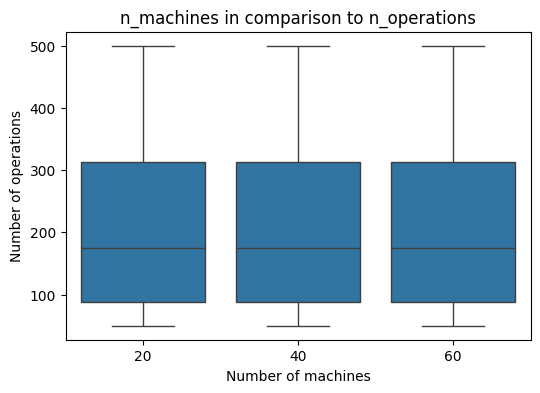

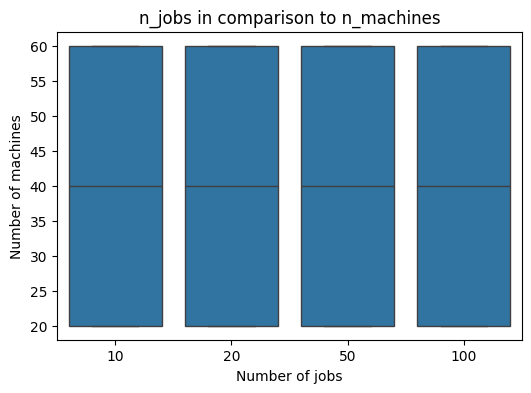

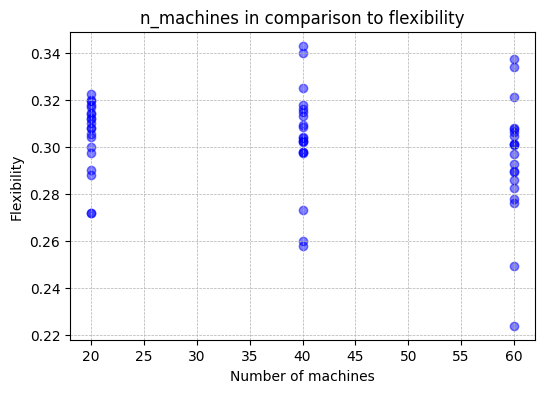

25.0% of all instances could be solved


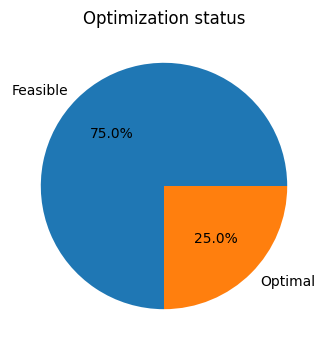

In [16]:
show_all_plots(behnke_merged)

#### Brandimarte

In [17]:
brandimarte = pd.DataFrame([x for i, x in data.iterrows() if x["name"].startswith("Brandimarte")])
brandimarte_encodings = get_encodings_for_group(brandimarte)
brandimarte_data = extract_data_from_encodings(brandimarte_encodings)
brandimarte_merged = pd.merge(brandimarte, brandimarte_data, on='name')
behnke_merged.describe()

,fitness_value,lower_bound,runtime,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,207.866667,83.583333,2702.768650,45.000000,40.000000,225.000000,0.301283,0.009000
std,122.419737,5.090009,1567.342177,35.295364,16.467739,176.476819,0.021509,0.007059
min,84.000000,73.000000,2.628000,10.000000,20.000000,50.000000,0.224000,0.002000
25%,109.000000,80.000000,2708.051500,17.500000,20.000000,87.500000,0.291900,0.003500
50%,170.500000,84.000000,3600.040000,35.000000,40.000000,175.000000,0.304000,0.007000
75%,272.500000,87.000000,3600.102500,62.500000,60.000000,312.500000,0.314100,0.012500
max,418.000000,97.000000,3600.360000,100.000000,60.000000,500.000000,0.343000,0.020000


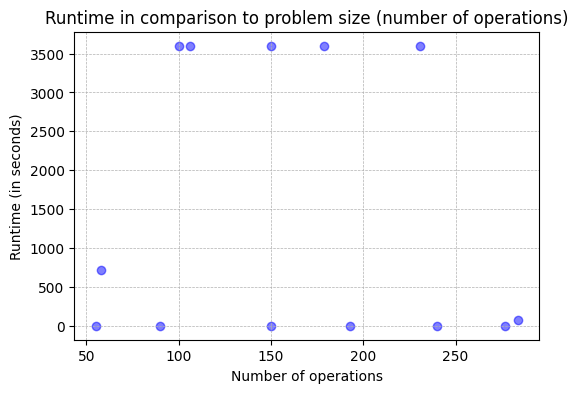

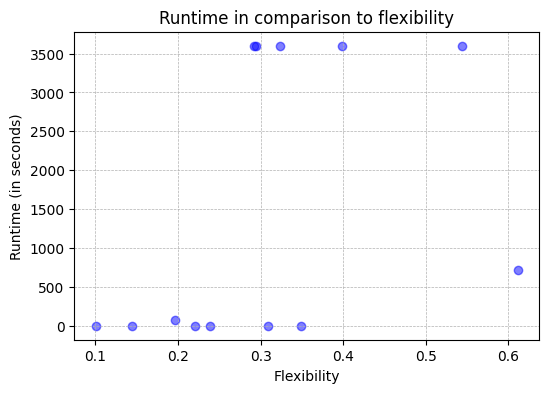

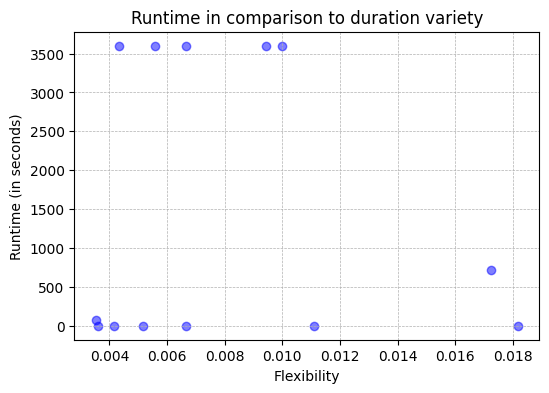

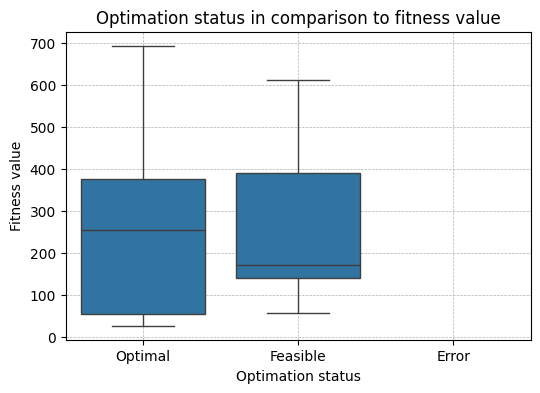

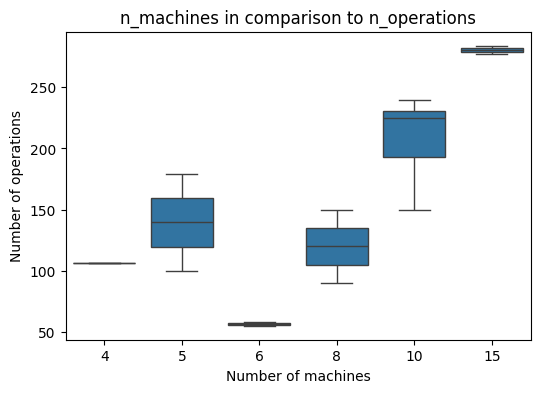

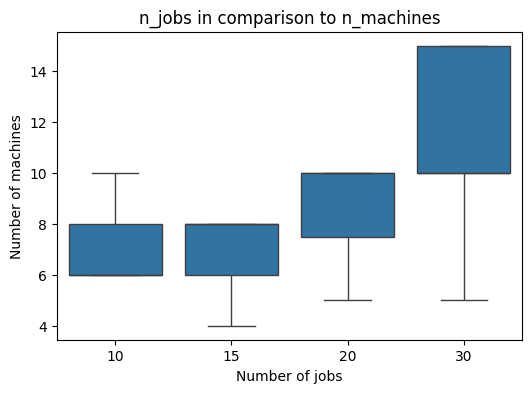

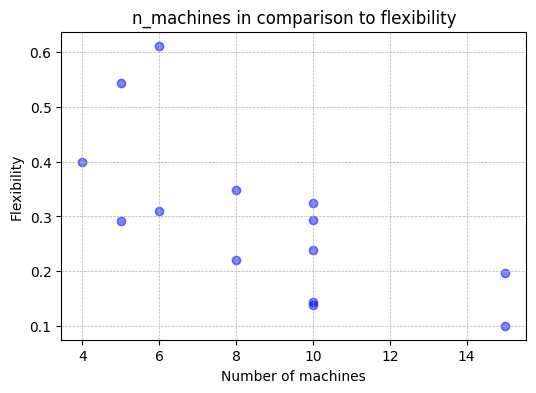

57.14285714285714% of all instances could be solved


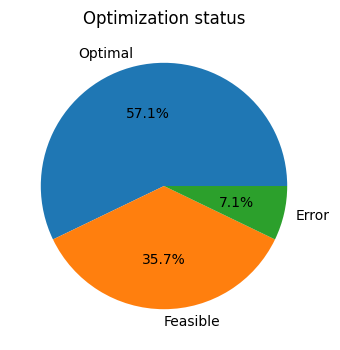

In [18]:
show_all_plots(brandimarte_merged)

#### HurinkS

In [19]:
hurinks = pd.DataFrame([x for i, x in data.iterrows() if x["name"].startswith("HurinkS")])
hurinks_encodings = get_encodings_for_group(hurinks)
hurinks_data = extract_data_from_encodings(hurinks_encodings)
hurinks_merged = pd.merge(hurinks, hurinks_data, on='name')
behnke_merged.describe()

,fitness_value,lower_bound,runtime,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,207.866667,83.583333,2702.768650,45.000000,40.000000,225.000000,0.301283,0.009000
std,122.419737,5.090009,1567.342177,35.295364,16.467739,176.476819,0.021509,0.007059
min,84.000000,73.000000,2.628000,10.000000,20.000000,50.000000,0.224000,0.002000
25%,109.000000,80.000000,2708.051500,17.500000,20.000000,87.500000,0.291900,0.003500
50%,170.500000,84.000000,3600.040000,35.000000,40.000000,175.000000,0.304000,0.007000
75%,272.500000,87.000000,3600.102500,62.500000,60.000000,312.500000,0.314100,0.012500
max,418.000000,97.000000,3600.360000,100.000000,60.000000,500.000000,0.343000,0.020000


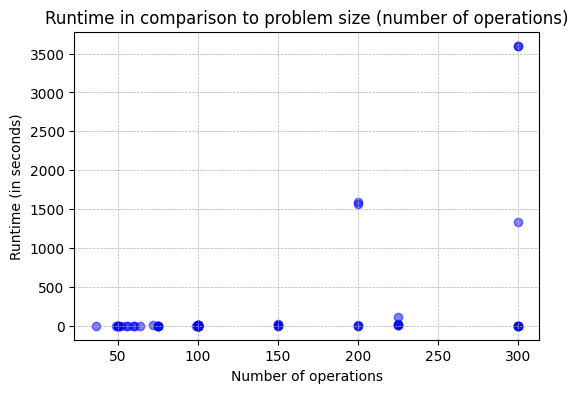

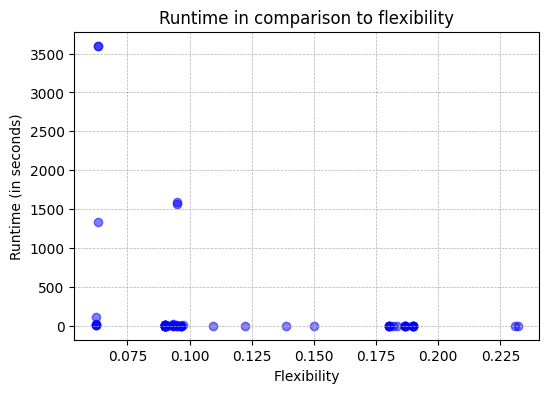

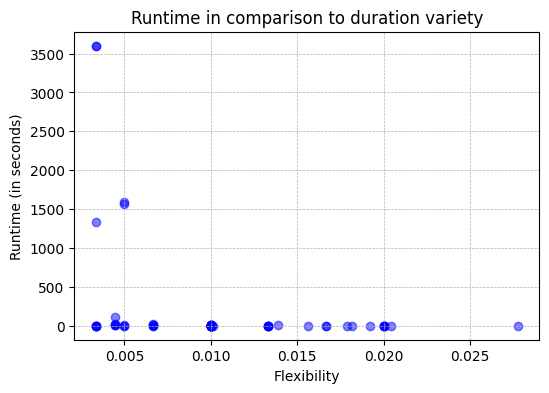

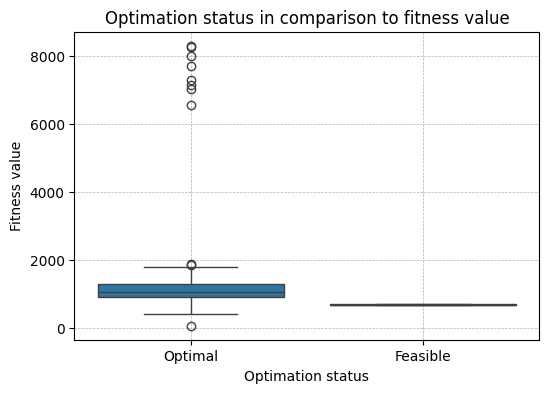

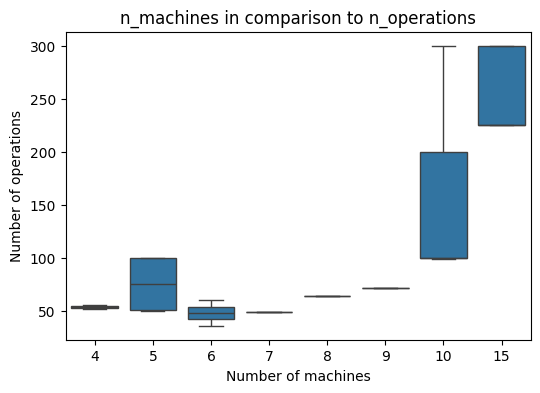

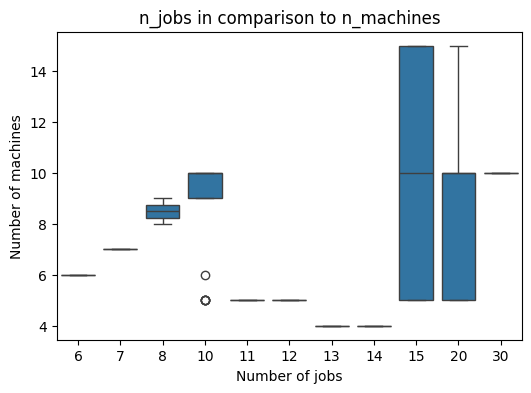

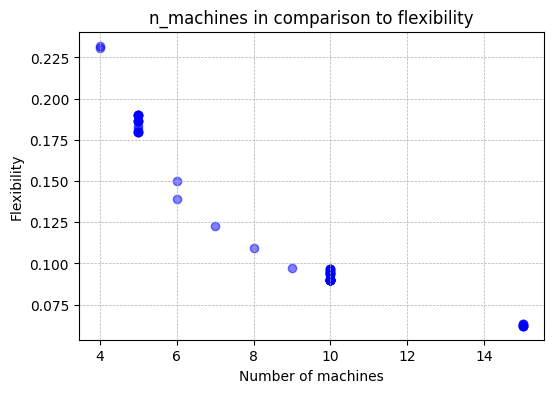

96.96969696969697% of all instances could be solved


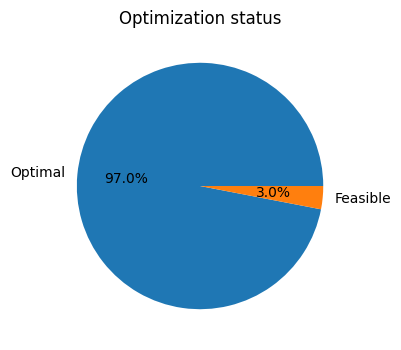

In [20]:
show_all_plots(hurinks_merged)

#### HurinkE

In [21]:
hurinke = pd.DataFrame([x for i, x in data.iterrows() if x["name"].startswith("HurinkE")])
hurinke_encodings = get_encodings_for_group(hurinke)
hurinke_data = extract_data_from_encodings(hurinke_encodings)
hurinke_merged = pd.merge(hurinke, hurinke_data, on='name')
hurinke_merged.describe()

,fitness_value,lower_bound,runtime,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,1697.212121,1692.772727,350.485621,14.757576,8.848485,133.378788,0.139186,0.010307
std,2028.861678,2030.681513,1001.055050,6.005281,3.235583,80.475465,0.057988,0.005566
min,55.000000,55.000000,0.055000,6.000000,4.000000,36.000000,0.070222,0.003333
25%,848.000000,848.000000,0.363750,10.000000,5.000000,75.000000,0.103000,0.005000
50%,959.000000,959.000000,1.544500,15.000000,10.000000,100.000000,0.108500,0.010000
75%,1177.500000,1165.250000,9.747750,20.000000,10.000000,200.000000,0.212000,0.013333
max,7990.000000,7990.000000,3600.020000,30.000000,15.000000,300.000000,0.281250,0.027778


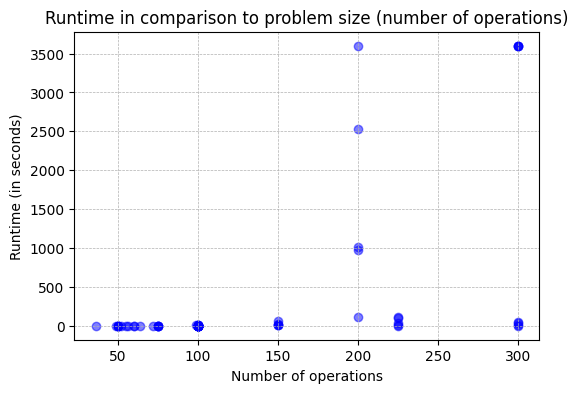

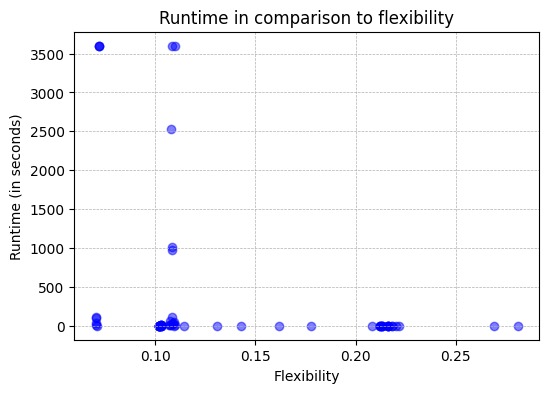

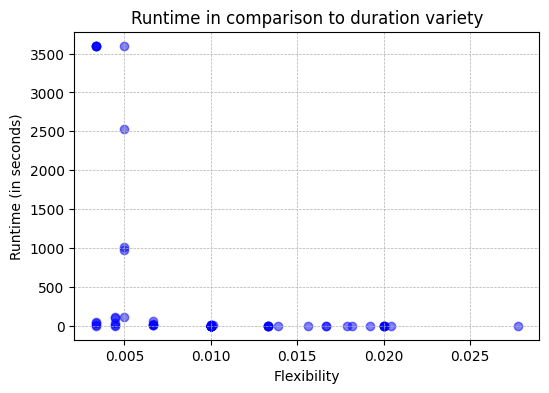

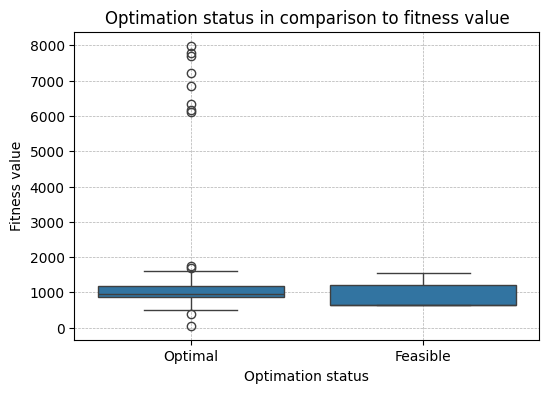

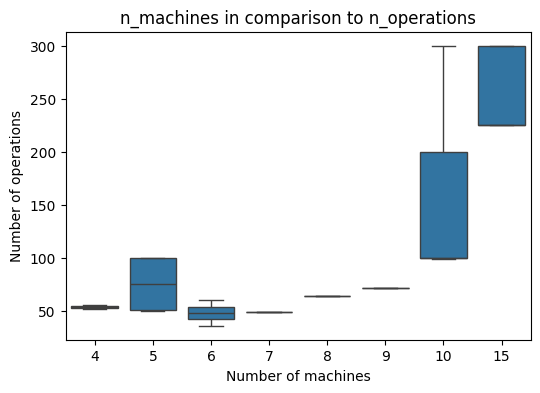

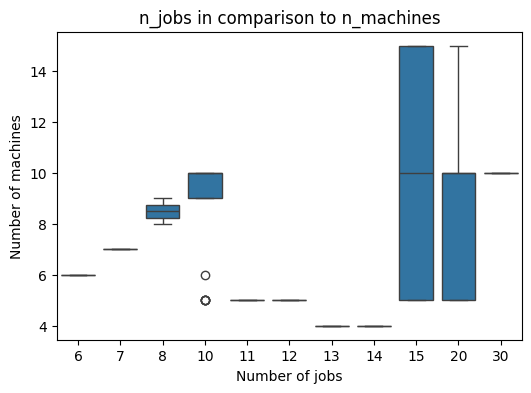

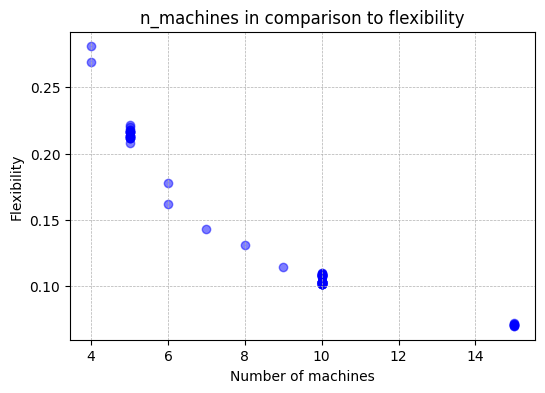

92.42424242424242% of all instances could be solved


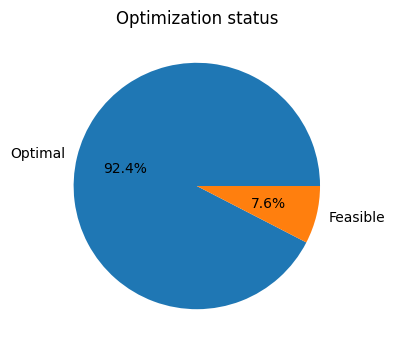

In [22]:
show_all_plots(hurinke_merged)

#### HurinkR

In [23]:
hurinkr = pd.DataFrame([x for i, x in data.iterrows() if x["name"].startswith("HurinkR")])
hurinkr_encodings = get_encodings_for_group(hurinkr)
hurinkr_data = extract_data_from_encodings(hurinkr_encodings)
hurinkr_merged = pd.merge(hurinkr, hurinkr_data, on='name')
hurinkr_merged.describe()

,fitness_value,lower_bound,runtime,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,1427.075758,1172.666667,1991.417015,14.757576,8.848485,133.378788,0.236801,0.010307
std,1613.108793,1381.643128,1769.967180,6.005281,3.235583,80.475465,0.095631,0.005566
min,47.000000,47.000000,0.031000,6.000000,4.000000,36.000000,0.120593,0.003333
25%,697.000000,631.250000,1.993000,10.000000,5.000000,75.000000,0.176000,0.005000
50%,824.000000,717.000000,3600.010000,15.000000,10.000000,100.000000,0.187667,0.010000
75%,1075.500000,859.250000,3600.010000,20.000000,10.000000,200.000000,0.354667,0.013333
max,6515.000000,6147.000000,3600.030000,30.000000,15.000000,300.000000,0.446429,0.027778


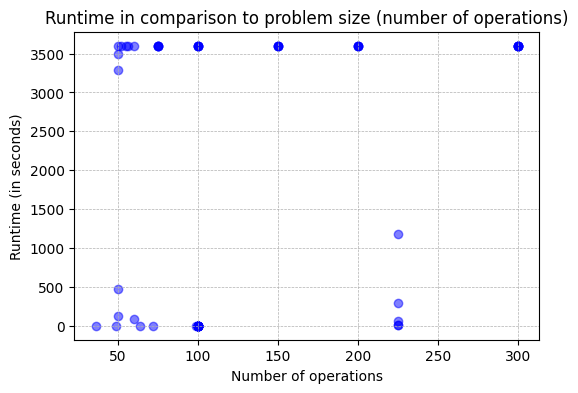

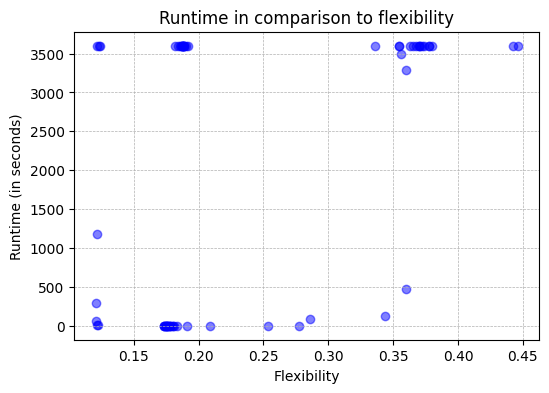

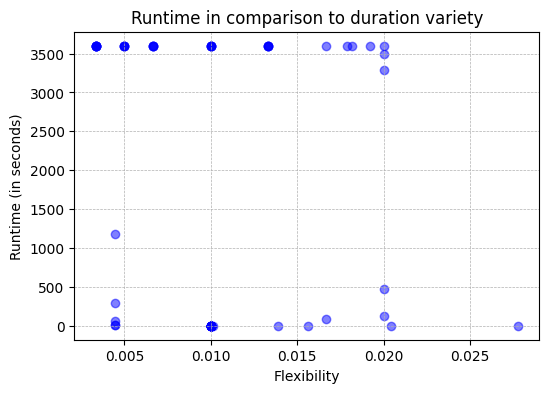

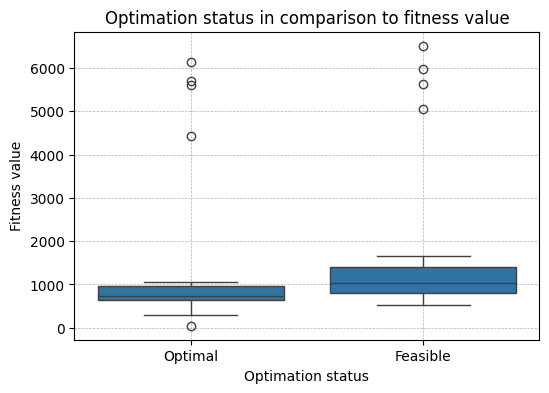

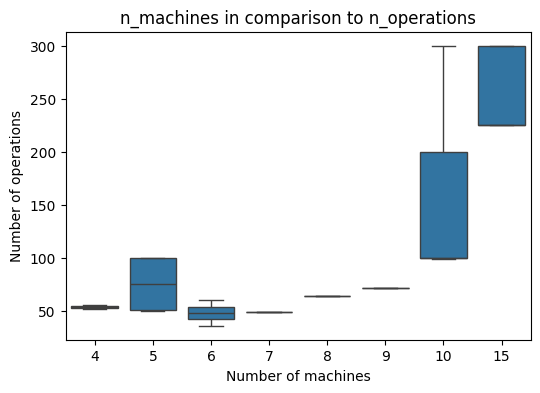

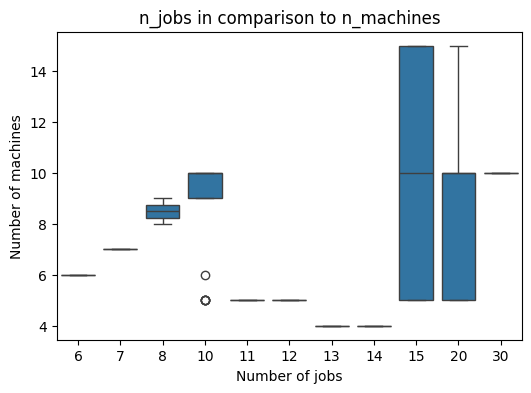

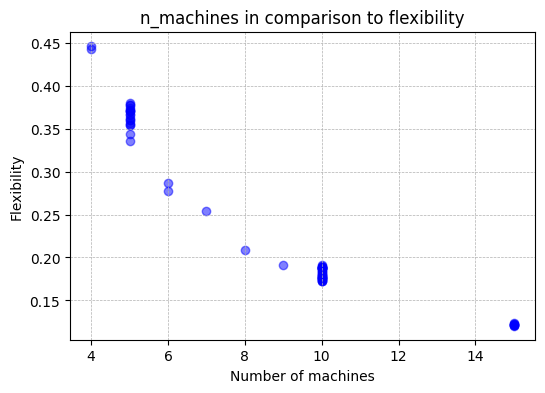

48.484848484848484% of all instances could be solved


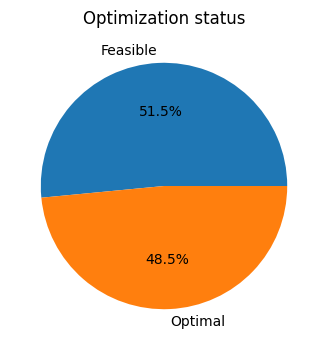

In [24]:
show_all_plots(hurinkr_merged)

#### HurinkV

In [25]:
hurinkv = pd.DataFrame([x for i, x in data.iterrows() if x["name"].startswith("HurinkV")])
hurinkv_encodings = get_encodings_for_group(hurinkv)
hurinkv_data = extract_data_from_encodings(hurinkv_encodings)
hurinkv_merged = pd.merge(hurinkv, hurinkv_data, on='name')
hurinkv_merged.describe()

,fitness_value,lower_bound,runtime,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,1365.712121,1029.545455,2127.378318,14.757576,8.848485,133.378788,0.438814,0.010307
std,1517.391403,1190.280564,1783.458890,6.005281,3.235583,80.475465,0.031943,0.005566
min,47.000000,47.000000,0.029000,6.000000,4.000000,36.000000,0.390000,0.003333
25%,656.000000,443.000000,0.189750,10.000000,5.000000,75.000000,0.417046,0.005000
50%,802.500000,661.000000,3600.010000,15.000000,10.000000,100.000000,0.428500,0.010000
75%,1069.750000,755.250000,3600.020000,20.000000,10.000000,200.000000,0.452000,0.013333
max,6514.000000,5486.000000,3600.070000,30.000000,15.000000,300.000000,0.524038,0.027778


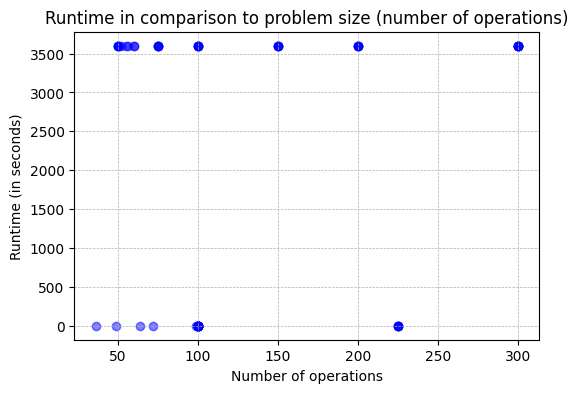

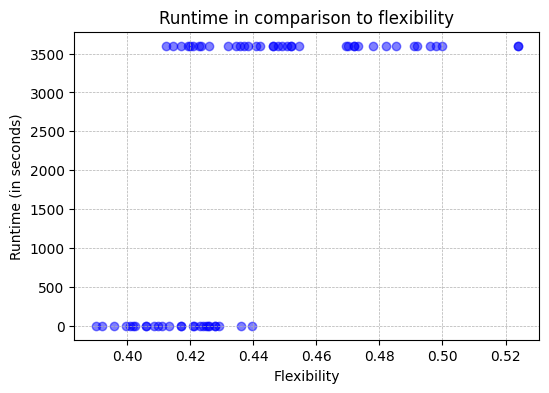

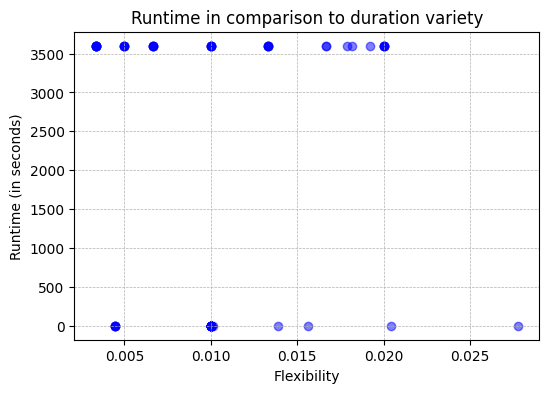

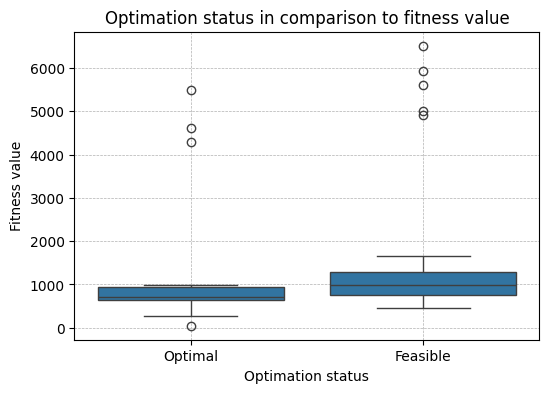

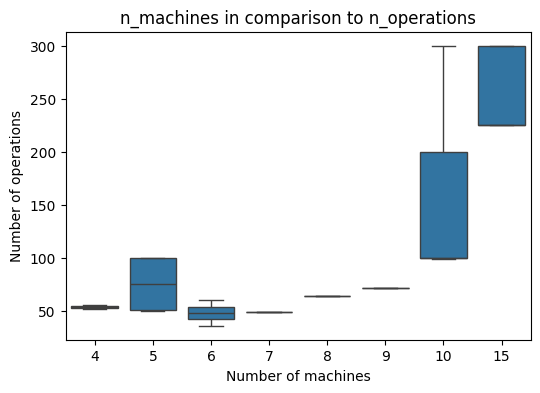

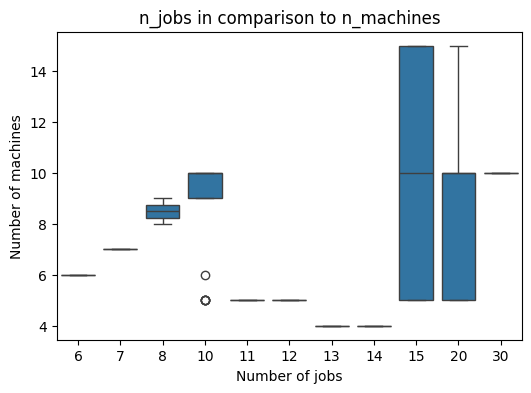

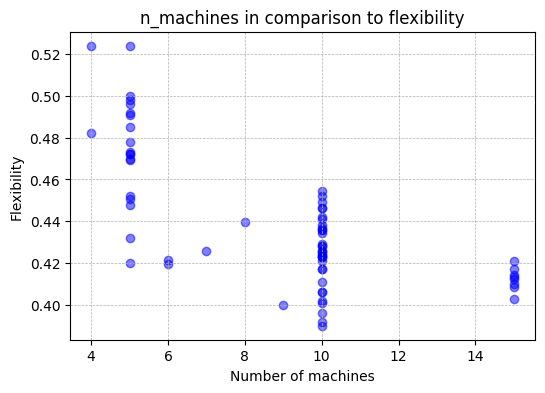

40.909090909090914% of all instances could be solved


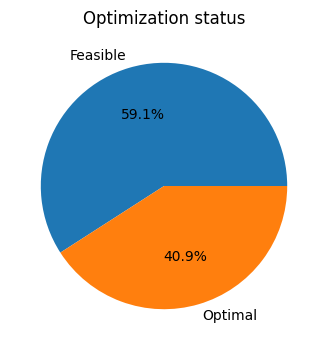

In [26]:
show_all_plots(hurinkv_merged)

#### ChambersBarnes

In [27]:
chambersbarnes = pd.DataFrame([x for i, x in data.iterrows() if x["name"].startswith("ChambersBarnes")])
chambersbarnes_encodings = get_encodings_for_group(chambersbarnes)
chambersbarnes_data = extract_data_from_encodings(chambersbarnes_encodings)
chambersbarnes_merged = pd.merge(chambersbarnes, chambersbarnes_data, on='name')
chambersbarnes_merged.describe()

,fitness_value,lower_bound,runtime,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,995.190476,995.190476,12.724429,13.333333,13.666667,158.333333,0.081852,0.007037
std,124.829732,124.829732,15.991615,2.415229,2.536402,52.638706,0.014291,0.002339
min,847.000000,847.000000,1.128000,10.000000,11.000000,100.000000,0.062222,0.004444
25%,910.000000,910.000000,2.984000,10.000000,12.000000,100.000000,0.062222,0.004444
50%,925.000000,925.000000,7.306000,15.000000,13.000000,150.000000,0.090000,0.006667
75%,1135.000000,1135.000000,15.172000,15.000000,16.000000,225.000000,0.093333,0.010000
max,1198.000000,1198.000000,65.795000,15.000000,18.000000,225.000000,0.093333,0.010000


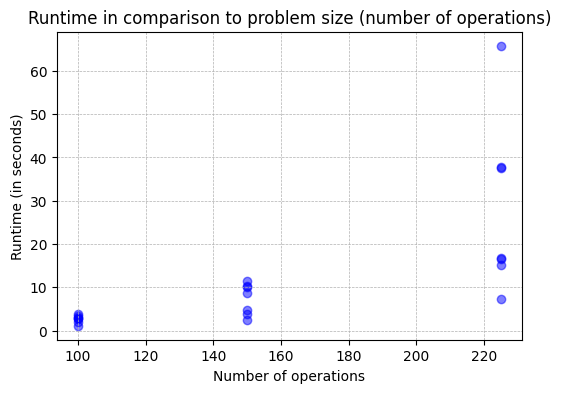

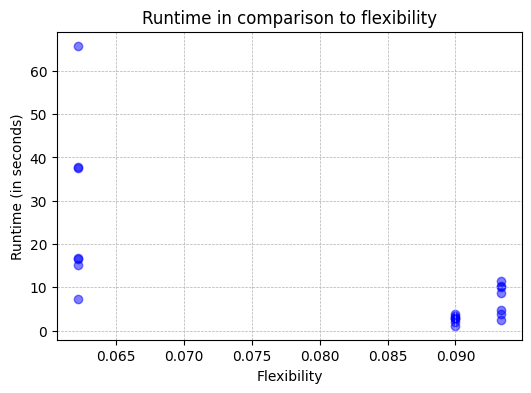

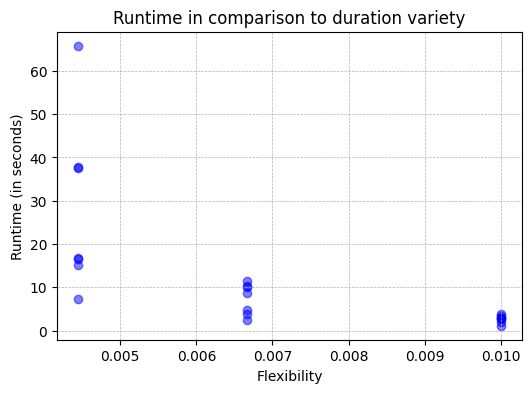

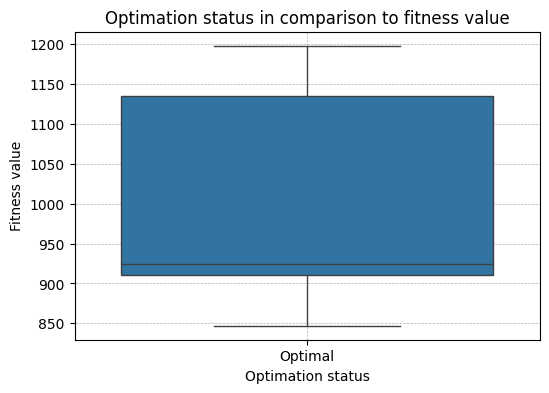

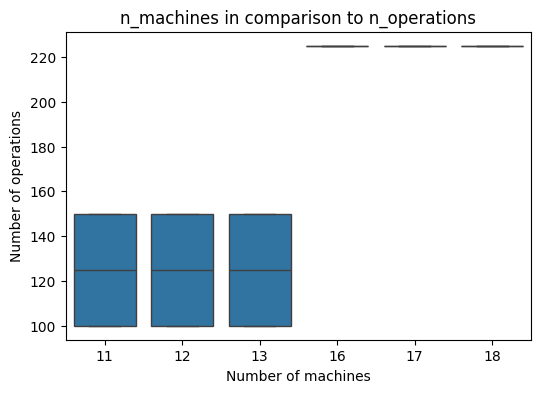

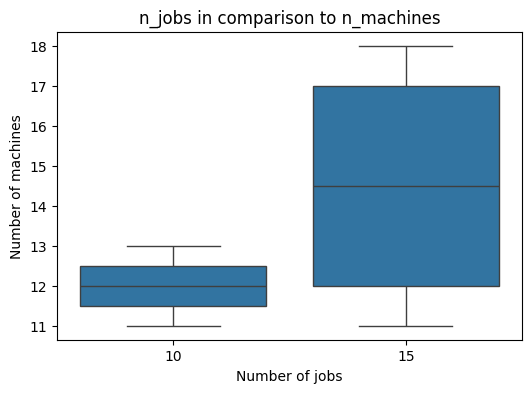

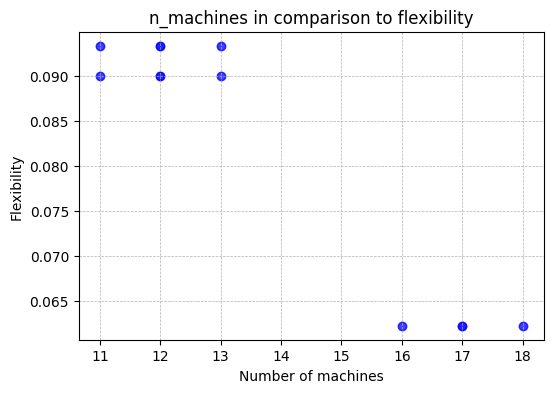

100.0% of all instances could be solved


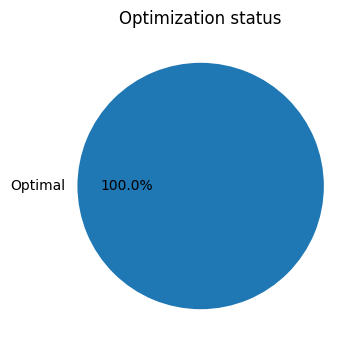

In [28]:
show_all_plots(chambersbarnes_merged)

#### Kacem

In [29]:
kacem = pd.DataFrame([x for i, x in data.iterrows() if x["name"].startswith("Kacem")])
kacem_encodings = get_encodings_for_group(kacem)
kacem_data = extract_data_from_encodings(kacem_encodings)
kacem_merged = pd.merge(kacem, kacem_data, on='name')
kacem_merged.describe()

,fitness_value,lower_bound,runtime,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,4.0,4.0,4.000000,4.00,4.00000,4.00000,4.000000,4.000000
mean,10.0,10.0,6.478500,9.75,8.00000,31.75000,0.889614,0.042252
std,2.0,2.0,12.878346,4.50,2.44949,18.15443,0.040171,0.028418
min,7.0,7.0,0.015000,4.00,5.00000,12.00000,0.833333,0.017857
25%,10.0,10.0,0.036750,8.50,6.50000,24.75000,0.880747,0.029464
50%,11.0,11.0,0.051500,10.00,8.50000,29.50000,0.898276,0.033908
75%,11.0,11.0,6.493250,11.25,10.00000,36.50000,0.907143,0.046695
max,11.0,11.0,25.796000,15.00,10.00000,56.00000,0.928571,0.083333


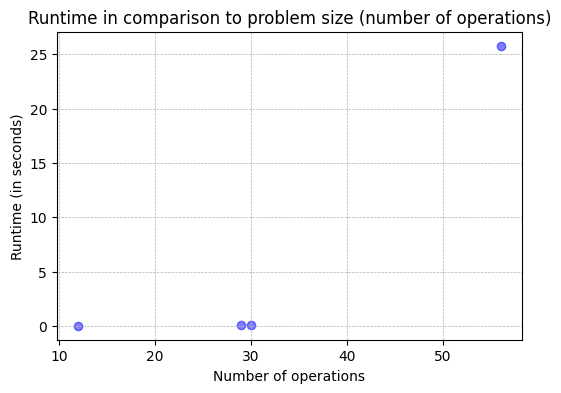

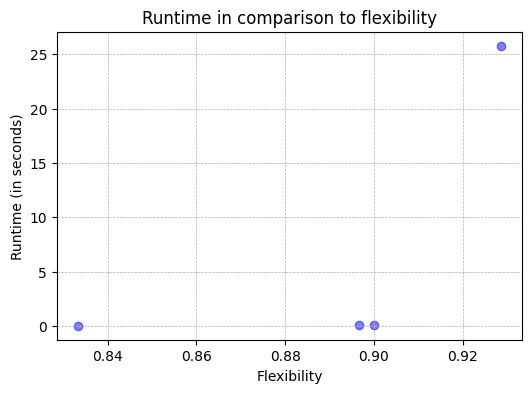

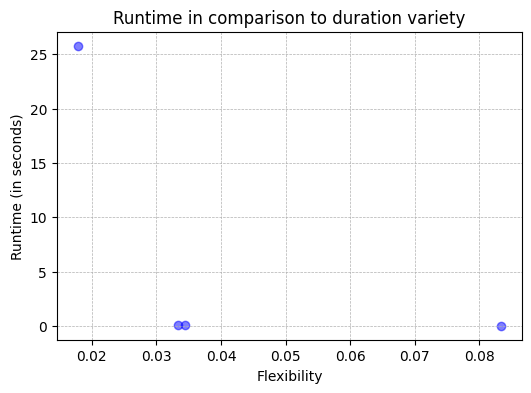

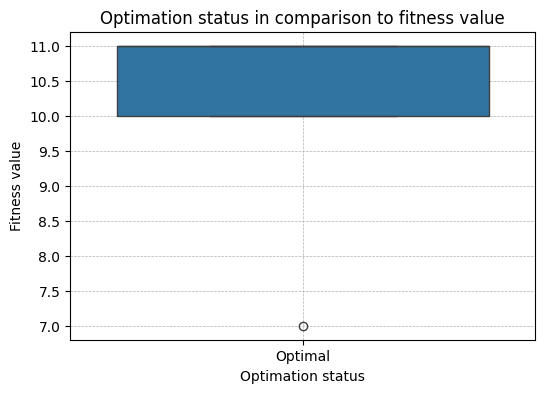

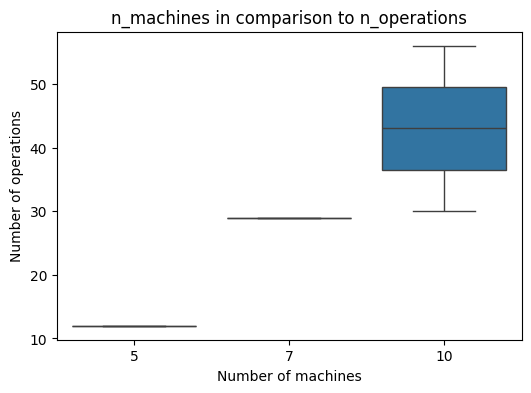

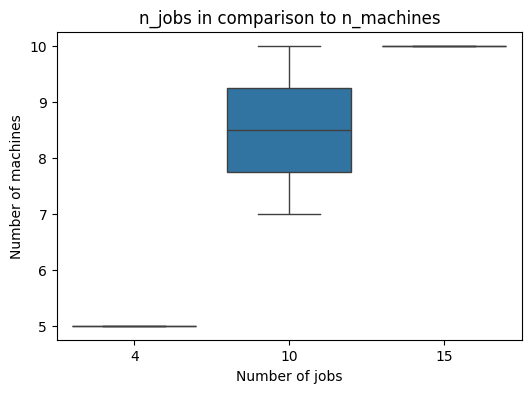

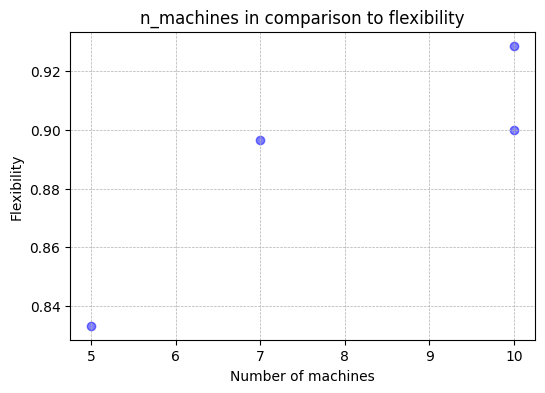

100.0% of all instances could be solved


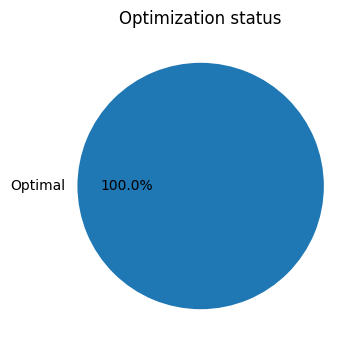

In [30]:
show_all_plots(kacem_merged)

#### Fattahi

In [31]:
fattahi = pd.DataFrame([x for i, x in data.iterrows() if x["name"].startswith("Fattahi")])
fattahi_encodings = get_encodings_for_group(fattahi)
fattahi_data = extract_data_from_encodings(fattahi_encodings)
fattahi_merged = pd.merge(fattahi, fattahi_data, on='name')
fattahi_merged.describe()

,fitness_value,lower_bound,runtime,n_jobs,n_machines,n_operations,flexibility,duration_variety
count,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000
mean,483.000000,483.000000,7.799450,5.350000,5.10000,17.400000,0.357130,0.097808
std,314.486047,314.486047,29.842264,3.013566,2.35975,13.268086,0.109249,0.070441
min,66.000000,66.000000,0.007000,2.000000,2.00000,4.000000,0.250000,0.020833
25%,245.000000,245.000000,0.016000,3.000000,2.75000,8.250000,0.276042,0.046131
50%,456.000000,456.000000,0.044500,4.500000,5.50000,13.500000,0.323129,0.075000
75%,574.000000,574.000000,0.197500,7.250000,7.00000,21.750000,0.392361,0.125000
max,1196.000000,1196.000000,133.200000,12.000000,8.00000,48.000000,0.666667,0.250000


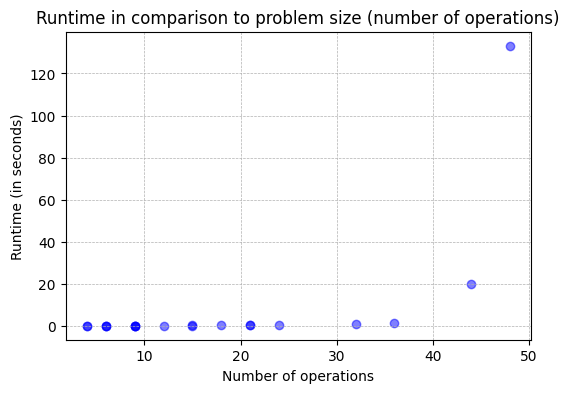

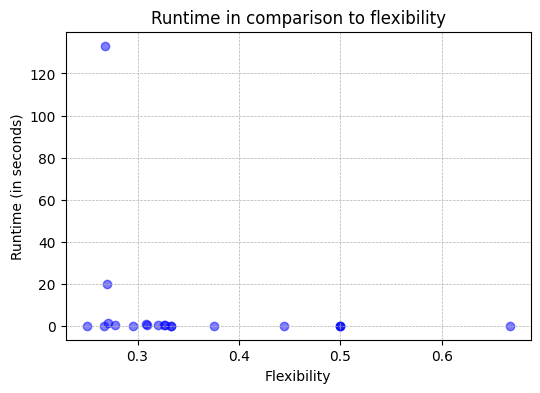

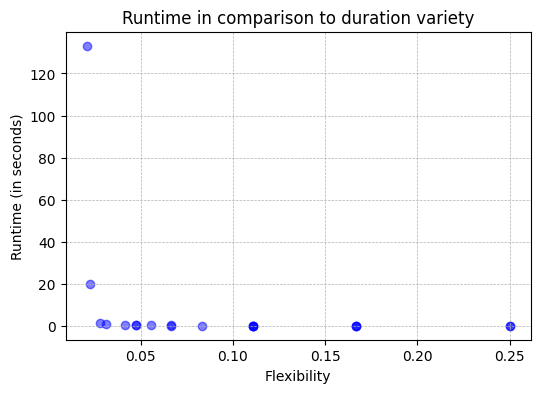

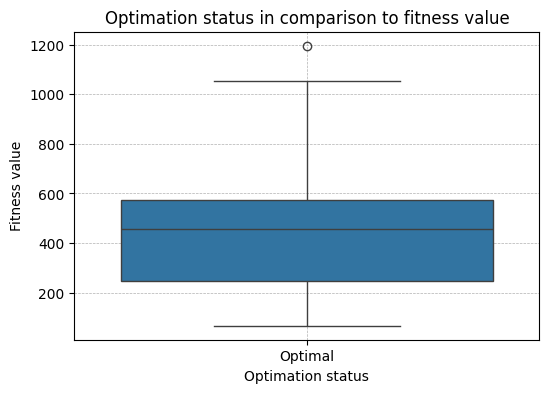

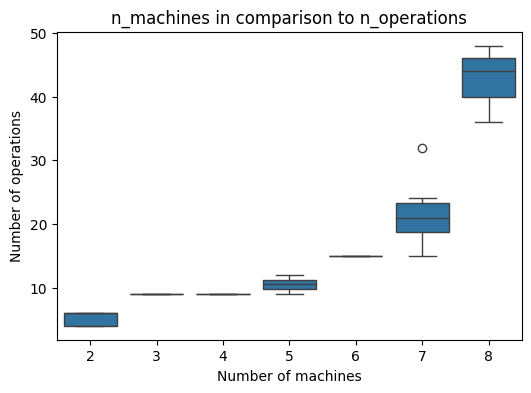

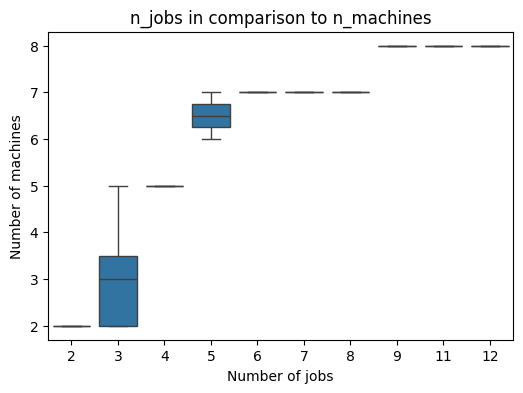

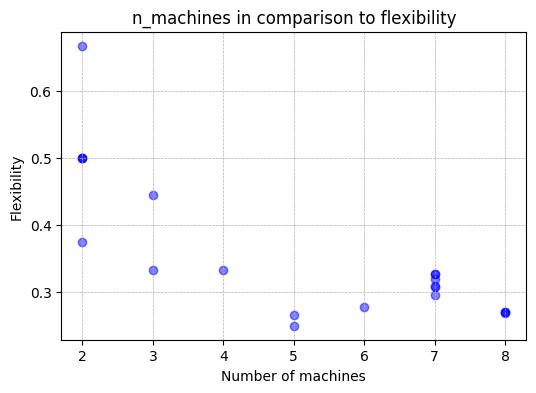

100.0% of all instances could be solved


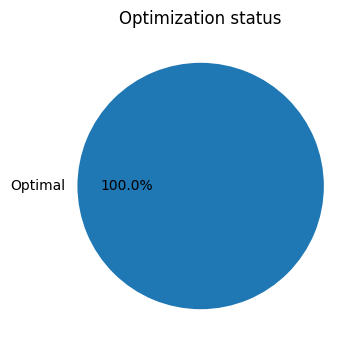

In [32]:
show_all_plots(fattahi_merged)